# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## <font color='red'>VERY IMPORTANT: if some of the following instructions is not followed, it will be penalized</font>

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 27th of october at 21:55**, using the **moodle platform**.
- Only **one submission by pair** of students
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "sofiane"
ln1 = "ennadir"
fn2 = "mohammed-amine"
ln2 = "abboudi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_ennadir_sofiane_and_abboudi_mohammed-amine.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[0. Test Numba](#numba)<br>
[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numba # available at: http://numba.pydata.org/numba-doc/latest/user/installing.html
from numba import njit

In [4]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [5]:
print(numba.__version__) # Your version of Numba

0.46.0


In [6]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
go_fast(x); # Running a first time the function to compile it

Iteration time of the Numba-compiled function.

In [7]:
%timeit go_fast(x)

1.16 µs ± 83.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [8]:
%timeit go_fast.py_func(x)

23.5 µs ± 527 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [9]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [10]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [11]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [12]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [13]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

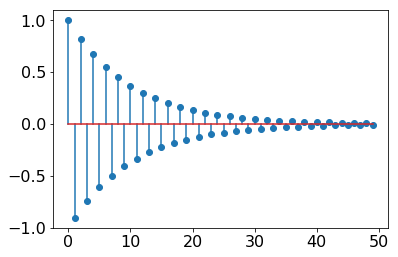

In [14]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [15]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.5088419395337191e-06

In [16]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.1314222507299931e-07

### Choice of the model

In [17]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [18]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06324055901226569


### Get a very precise minimum to compute distances to minimum

In [19]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5127698090784896
1.019203442117575e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [20]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [21]:
# Number of full batch iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q1) Fill in the iteration of the GD solver in the cell below

In [22]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = x - step * grad(x, A, b, lbda)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [23]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q2) Fill in the iteration of the AGD solver in the cell below

In [24]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_old = x.copy()
        t_old = t
        x = y - step * grad(y, A, b, lbda)
        t = 0.5 * (1 + np.sqrt(1 + 4 * t_old**2))
        y = x + (t_old - 1)/(t) * (x - x_old)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [25]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [26]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [27]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [28]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(21, 9))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    plt.figure(figsize=(21, 9))
    for monit in monitors:
        errs = monit.err
        plt.semilogy(np.linspace(0, monit.total_time, len(errs)), errs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)

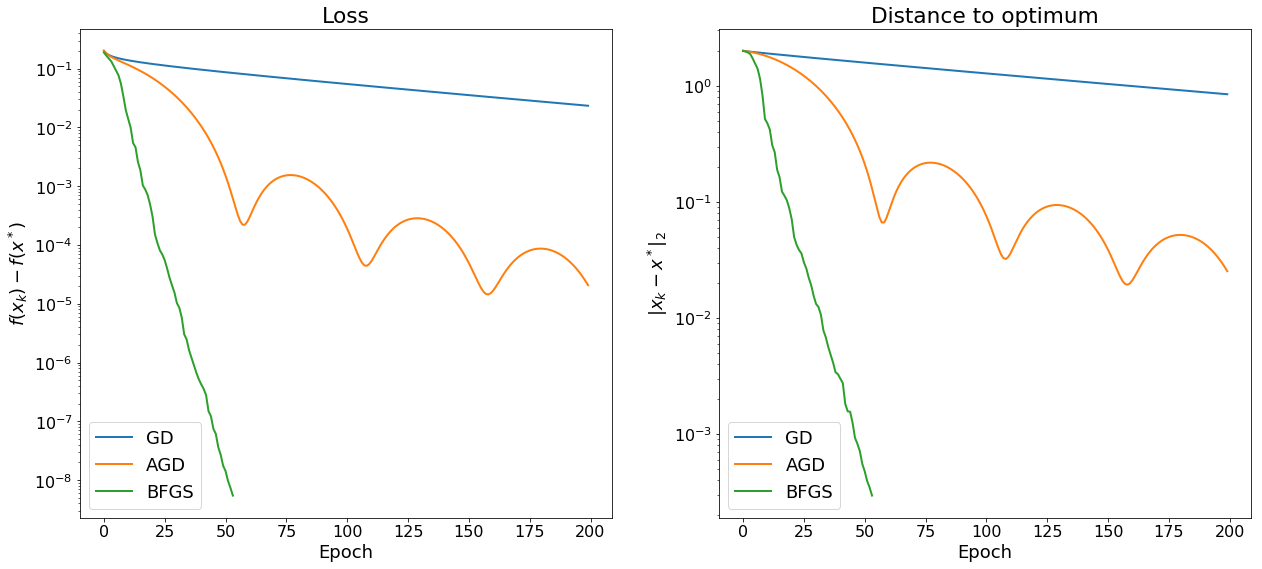

In [29]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs]

solvers = ["GD", "AGD", "BFGS"]

plot_epochs(monitors, solvers)

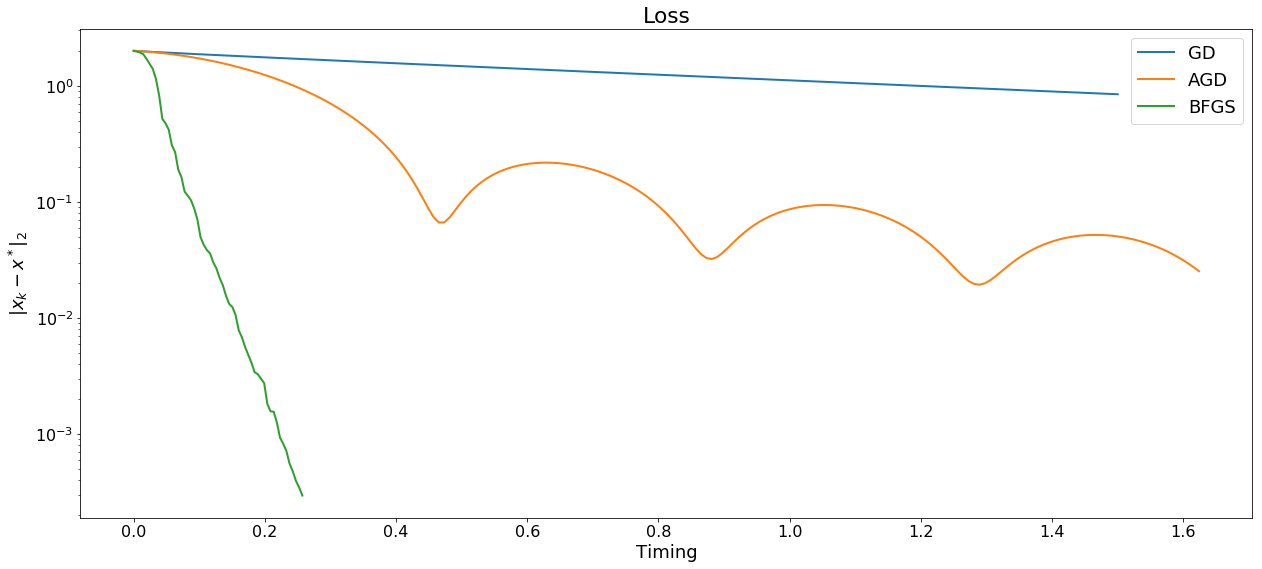

In [30]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q3) Give some first conclusions about the batch solver studied here
- Q4) What do you observe about AGD? is it suprising ?

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER TO QUESTION 3 & 4</span>
<ul>
Based on the visual results of plotting the loss function, the distance to the optimum with respect to epochs as well as with respect execution time (for loss only) of both <b>Gradient Descent (ISTA) </b> and <b>Accelerated Gradient Descent (FISTA)</b>, we offer the following first impressions:
<li>
    <b> GD </b> is the slowest algorithm. Furthermore, using the convexity and L-smoothness of $f$ we can prove that :
$$
        f(x^{(k)}) - f(x^*) \leq \frac{L  ||x^{(0)}-x^*||^2}{k}
$$
    Hence, GD with fixed step-size converges at least as fast as $\left(\frac{1}{k}\right)$.
</li>
    <li>
        <b> AGD </b>  is the the second fastest, for it is proven to arrive at the optimal solution with convergence rate $\mathcal{O} \left(\frac{1}{k^2}\right)$, thanks to the following inequality : $$f(x^{(k)} - f(x^*) \leq \frac{4L  ||x^{(0)}-x^*||^2}{(k+2)^2}$$
        
We notice that the evolution of both the metrics exhibits some sort of periodic behavior, which at first glance raises questions. Indeed, over the first half of each period we see that the algorithm moves away from the optimum solution, which should not be occuring in a gradient descent algorithm. Hence a key distinction between GD methods and pure GD methods is to be made. Accelerated methods belong to the non-pure GD family of algorithms and so are not guaranteed to be monotonous in the objective value. <a href="https://statweb.stanford.edu/~candes/papers/adap_restart_paper.pdf">This paper</a> shows that the period of such ripples referred to as momentum is dependant on the condition number of the loss function. The condition number for our case is the Lipschitz contant $L$. Generating another design matrix with minor changes to its values does not bring about detectable changes to the loss function's curve. We rather change the number of observation as well as the size of the feature space (from 50 to 1000) we can clearly see in the figure below that the ripples are much smoother eventhough the algorithm does not seem to converge any faster (which is expected). $$ $$So it is not that surprising. There are some evident implementation ideas to mitigate the effect of such ripples, one could be rejecting a solution that increases the loss fucntion while continuing to iterate in the background until the loss decreases, then affect the solution's value to the next iterate $x^{(k+1)}$.
</li>
        <img src= "loss_agd_1000.png" alt="AGD w/ 1000 features" style="width: 600px;"/>
<li>
    For the last Algorithm that has been used - The Limited Memory BFGS (Broyden–Fletcher–Goldfarb–Shanno) algorithm is for sure the fastest in term of speed, but it did stop earlier than the other algorithm and didn't reach to total point of convergence which was reached by AGD and GD. When refering <a href="http://www.lix.polytechnique.fr/bigdata/mathbigdata/wp-content/uploads/2014/09/notes_quasi_newton.pdf">This document</a>, we understood that it's normal that the algorithm is working fine in our case because of ease in the approximation of the hessian in our case.
    
The choice of an ultimate algorithm is therefore not evident and is highly contingent on the its use-case.
</li>
</ul>
</div>

<a id='stoc'></a> 
## 4. Stochastic methods
*WARNING*: for stochastic methods ``n_iter`` corresponds to the number of epochs (number of full pass across the data)

In [31]:
n_iter = 200 # here corresponds to the number of epochs

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)
len(iis)

2000000

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Q5) Fill in the iteration of the SGD solver in the cell below

In [32]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x -= step/np.sqrt(idx+1) * grad_i(i, x, A, b, lbda)
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [33]:
step0 = 1e-2
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q6) Fill in the iteration of the SAG solver in the cell below

In [34]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        
        # Recall during the course, we have used the following method
        # to make our algorithm more effectient.
        # In fact, and because we're only updating in one direction
        # we can directly only replace that direction in G without 
        # recompling all the sum.
        
        averaged_gradient -= gradient_memory[i]/n
        gradient_memory[i] = grad_i(i,x,A,b,lbda)
        averaged_gradient += gradient_memory[i]/n
        
        x -= step * averaged_gradient
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [35]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q7) Fill in the iteration of the SVRG solver in the cell below

In [36]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_ref = x.copy()
    x_list = []
    m = 500
    for idx in range(n_iter):
        
        if idx % n == 0:
            x_ref = x.copy()
            mu = grad(x_ref,A,b,lbda)
            
        i = iis[idx]
        x = x - step * (grad_i(i,x,A,b,lbda) - grad_i(i,x_ref,A,b,lbda) + mu)
        
        if idx % store_every == 0:
            x_list.append(x.copy())
    
        ### END TODO
        # Update metrics after each iteration.

    return x, x_list

In [37]:
# grad i at x_ref

x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

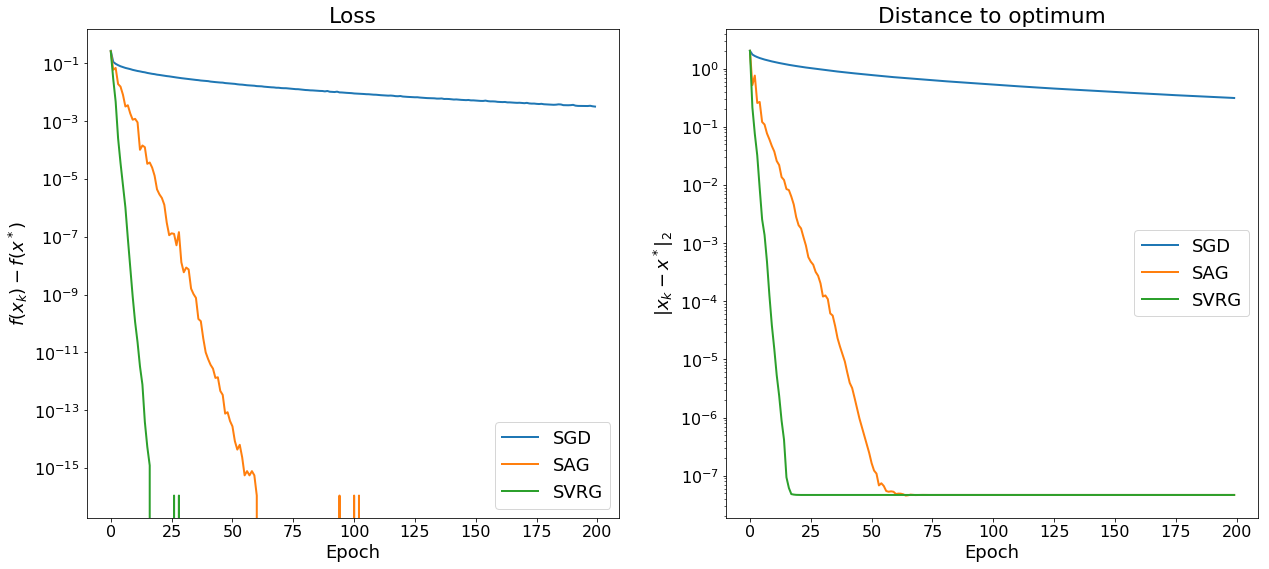

In [38]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

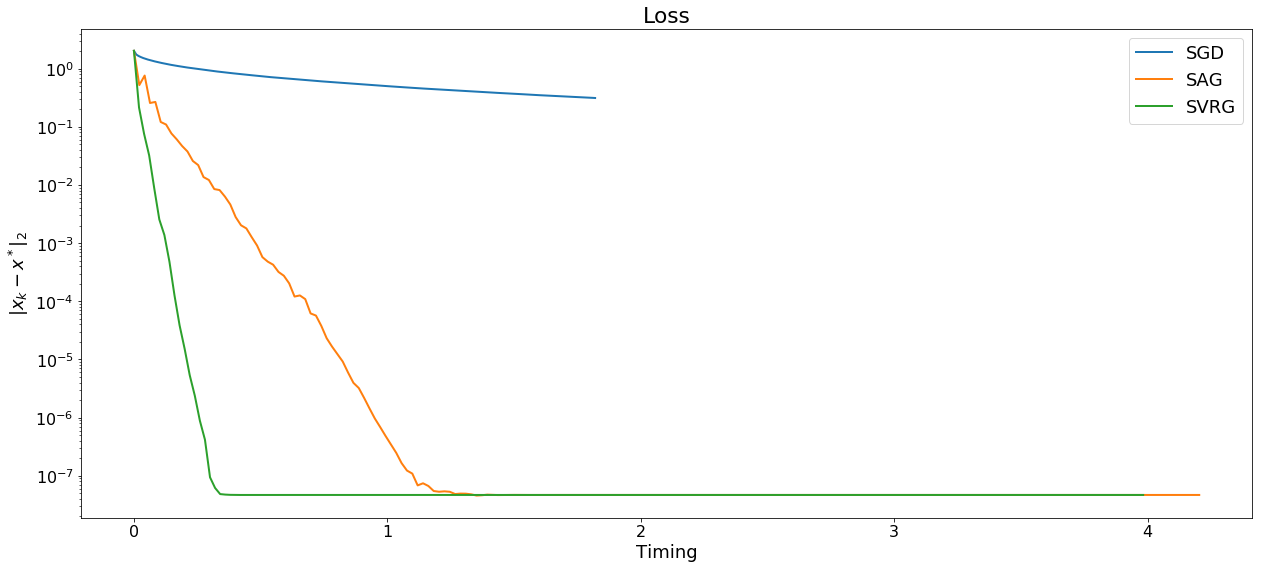

In [39]:
plot_time(monitors, solvers)

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER TO QUESTION 8</span>
<ul>
    
<li>The fastest algorithm is the SVRG, the second fastest is the SAG while the SGD is the slowest. </li>
    <li> The SVRG and the SAG converge to the same value, each one in a different number of iterations, naturally. The SGD usually doesn't converge to this point because it goes to a local optimum, the quality of which is hight dependant on the initial value the x vector.  </li>
    <li> Normally the SAG should be much slower than this, but because we used the "Hybrid" version of SAG that was introduced during the lecture, we don't need to compute the entire sum at each time, and therefore it's much faster (less complex) now but still a little bit slower than the SVRG, which does not need to store the entire gradient matrix and the majority of the operation costs only $\mathcal(O)(1)$. </li>

</ul>
</div>

<a id='comp'></a> 
## 5. Numerical comparison

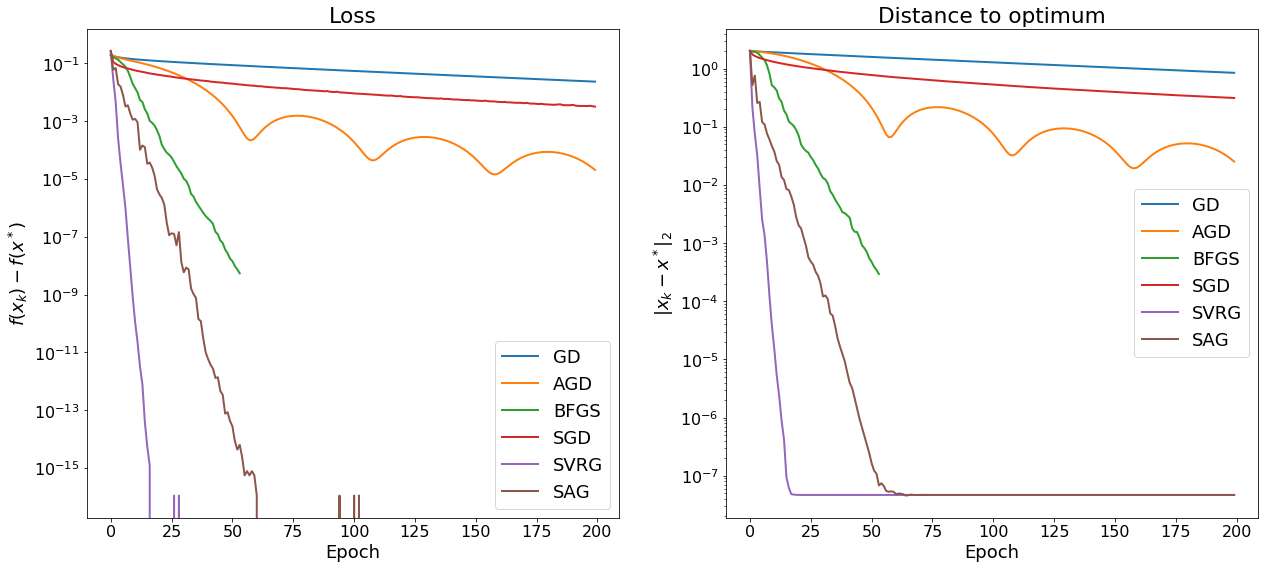

In [40]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_svrg, monitor_sag]

solvers = ["GD", "AGD", "BFGS", "SGD", "SVRG", "SAG"]

plot_epochs(monitors, solvers)

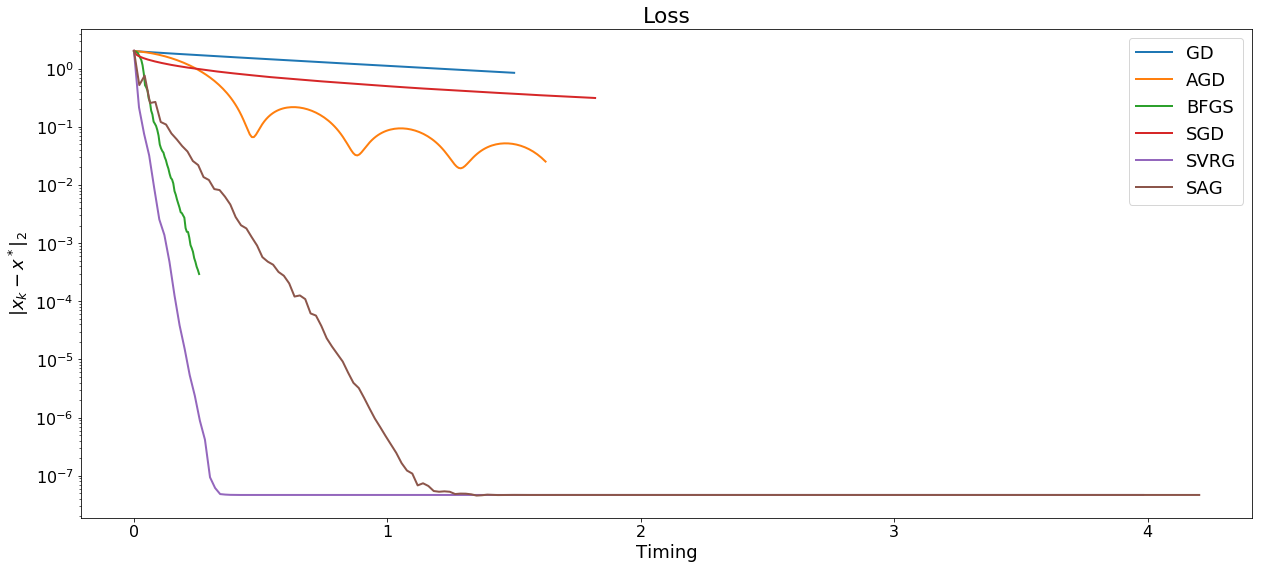

In [41]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:

For all the following questions, try to show only **FEW INFORMATIVE FIGURES** that highlight your conclusions.
- Q9) Compare the deterministic and the stochastic gradient methods. Comment your results.
- Q10) Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Q11) Look carefuly on how the data are generated in functions  ``simu_linreg`` and ``simu_logreg``. Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Q12) Change the number of data points $n$ and the number of data samples $d$ and compare your results. Comment.
- Q13) Conclude on the performance on the implemented methods. Are their "regimes" for which some methods are faster than others?
- Q14) Are there different behaviours between the deterministic methods? What about the stochastic ones?
- Q15) Compare the memory, the number of hyper-parameters to tune and the ease of implementation of each algorithm. According to this, in which configuration do you think a user should use deterministic method rather than a stochastic one, and vice-versa?

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER TO QUESTION 9</span>
<ul>
Based on the visual results of plotting the loss function, the distance to the optimum with respect to epochs as well as with respect execution time (for loss only) of <b>Stochastic Gradient Descent (SGD) </b>, <b>Stochastic averaged  Gradient (SAG)</b> and <b> Stochastic Variance Reduced Gradient (SVRG) </b> as well as the previous deterministic full-batch methods we offer the following distinctions:
<li>
    Although faster than both <b> GD </b> and <b> AGD </b>, <b> SGD </b> is the slowest stochastic algorithm. It is much noisier, making it less precise. It is however slower than L-BFGS by a significant margin (L-BFGS is less noisy as well). The compromise is therefore to be made regarding accuracy, irrespective of number of epochs or time, the early stopping characteristic of L-BFGS constricts it from moving towards a better solution, which could prove disadvantageous in certain situations.
</li>

<li>
        <b> SAG </b> is faster than all the deterministic methods when it comes to tracking progress per epoch. However when it comes to evolution over time, <b> SAG </b> lags slightly behind L-BFGS which is rather surprising given that it's a full-batch algorithm. This increment in time sensitive speed is due to L-BFGS' approximation of the BFGS algorithm through memory restriction. On another note regarding accuracy, <b> SAG </b> is able to arrive at the same optimal solution as <b> GD </b> and <b> AGD </b> (<b>see figure below</b>), which is quite interesting since such methods only approximate the full gradient (for the most part).
</li>
        <img src= "loss_5000_all.png" alt="AGD w/ 1000 features" style="width: 600px;"/>
<li>
    Finally, <b> SVRG </b> is the fastest amongst all the methods implemented in terms of convergence with respect to epochs. However when it comes to raw execution time, SVRG takes around 5 seconds to finish the 200 epochs, SAG takes slightly over 4 seconds while all the other methods with the exception of L-BFGS finish almost at the same time at 1.5 seconds. Furthermore, SAG and SVRG arrive at their optimal solution after only 1 second and 0.5 seconds, making them in the final analysis faster than all other methods. A stopping criterion is highly recommended! 
</li>
</ul>
</div>

Due to some issues in the code, the problem stems mainly from the fact that global and local variables seem to be used in an interchangeable manner, and to avoid making any major changes to the main code we only use screenshots to illustrate our responses. We have simply changed the desired parameters and included a picture of the result.

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER TO QUESTION 11</span>
<ul>
<b>
    Description:
</b>
<li> Changes in correlation affect the behavior and ranking of almost all the algorithms. Previously, SVRG was the fastest both with respect to time and epochs, now GD is the fastest (converges in less than 25 epochs and 0.2 seconds) followed by AGD then SVRG, SAG and finally SGD. More than that, a lower correlation helped produce a better solution $(|x^k - x^*|\leq 10^{-9})$ by almost two orders of magnitude.
    
</li>
        <img src= "corr_0.1_200.png" alt="Correlation of 0.1" style="width: 600px;"/>
        <img src= "corr_0.1_200t.png" alt="Correlation of 0.1" style="width: 600px;"/>
<li>
<b>
    Explanation :
</b>
        
</li>
        This is to be expected since in the case of high correlation, information is replicated across a majority of features and or obeservations. Hence, it is uselessly laborious to compute the full gradient as opposed to targeting individual observations which ultimately carry the same information. That is why, a single iteration in the case of the stochastic methods could have almost the same magnitude as an iteration of a full-batch one. Also the design matrix has a smaller norm, which could affect learning speed.
<li>
    On the other hand, in the case of low correlation, each observation is fuller of new information and so it can be advantageous to compute the entire gradient since it is much more meaningful and less prone to wasted processing power which led in this case to a better solution in less time. Here we see the strength of such deterministic algorithms.
</li>
</ul>
</div>

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER TO QUESTION 12</span>
<ul>
<b>
    Description:
</b>
<li> After changing the number of data points $n$ we notice minor changes when it comes to evolution over epochs, mainly all the curves seem to get closer to each other. However, when we compare methods with respect to time, we can see that SAG outperforms SVRG slightly. Which means that it has significanly decreased in processing time, roughly from 1.2 seconds to 0.25 seconds.
        <img src= "n=1k,d=50.png" alt="n = 1000, d = 50" style="width: 600px;"/>
        <img src= "n=1k,d=50t.png" alt="n = 1000, d = 50" style="width: 600px;"/>
</li>
    
<li>
    Now we change the size of the feature $d$. We have already briefly discussed some consequences of such change in the answer to question 4. Mainly increasing the number of features causes an increase in the learning rate which is directly resposible for the magnitude of the ripples (a consequence of a lower learning rate). Furthermore, we only notice changes in the convergence time of the algorithms where all of them suffered from an increase. SVRG went from converging in 0.4 seconds to over 1.3 seconds. SAG from 1 second to 4.2.
    
    
    
</li>
        <img src= "n=10k,d=500.png" alt="n = 10.000, d = 500" style="width: 600px;"/>
        <img src= "n=10k,d=500t.png" alt="n = 10.000, d = 500" style="width: 600px;"/>
<b>
    Explanation :
</b>
<li>
    Lower the number of samples has greatly benefited the execution time of the SAG, that could be explained by the massive decrease in the size of the $d \times n$ matrix saved by the algorithm whcih is changed to a tenth of its previous size in this case. So it is only keeping track of a tenth of the parameters.
        
</li>
<li>
    Increasing the size of the feature space would evidently lead to slower convergence speed (more epochs and expecially more time). However since the correlation is still quite high, the quality of the solution remains unchanged, whcih is to be expected because even though it may seem as if we are adding information, however that information is highly redundant to it only slows down the algorithms.
        
</li>
</ul>
</div>

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER TO QUESTION 13</span>
<ul>
    To conclude, we can see that the implemented methods differ in performance based on the nature of the data. More explicitely:
<li>
    In high correlation, stochastic methods converge faster.
</li>
<li>
    In low feature and sample correlation, deterministic problems converge faster and to more precise solution.
</li>
<li>
    When the the sample size is quite small, it is better to use an averaging stochastic algorithm if time is more crucial to the use-case.
</li>
</ul>
</div>

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER TO QUESTION 14</span>
<ul>
<li>
    <b> Behavior between deterministic methods</b>: AGD is sensitive the level of regularization regarding the amplitude of its "bumps", a higher penalization making it more precise. GD outperforms AGD, even though AGD starts on a slight advance when correlation is quite low. The time/epochs that it GD to catch up to AGD seem to be dependant on the level of correlation as well as the size of the design matrix. (Playing around with these parameters makes it easier to explor the different behaviors exhibited by the implemented algorithms).
</li>
<li>
    <b> Behavior between stochastic methods</b>: SAG outperforms all other algorithms when sample size or number of features is small (as detailed above) and correlation is higher. SVRG is better otherwise.
</li>
</ul>
</div>